In [13]:
import numpy as np
np.random.seed(3)
from pybedtools import BedTool
import pybedtools
import pandas as pd
import seaborn as sns

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout,BatchNormalization,Activation
from keras.layers import Conv1D, MaxPooling1D,Conv2D,MaxPooling2D,GlobalAveragePooling1D, AveragePooling1D
from keras.layers import Dropout
from keras.optimizers import Adam,RMSprop
from keras import regularizers as kr
from keras import initializers
from keras.callbacks import EarlyStopping
from keras.utils import np_utils, to_categorical
# custom R2-score metrics for keras backend
from tensorflow.python.keras import backend as K
import matplotlib.pyplot as plt

import os
from sklearn.metrics import r2_score
from tensorflow.python.keras.callbacks import EarlyStopping

from sklearn import linear_model
from sklearn.svm import LinearSVC

import random

In [14]:
#parameter setting...
cell_type = 5
apply_sample_weight = False
target_length = 600
filter_length = 5

In [15]:
def read_data(bed_file,fasta_file):
    #apply bedtools to read fasta files '/home/h5li/methylation_DMR/data/DMR_coordinates_extended_b500.bed'
    a = pybedtools.example_bedtool( bed_file )
    # '/home/h5li/methylation_DMR/data/mm10.fasta'
    fasta = pybedtools.example_filename( fasta_file )
    a = a.sequence(fi=fasta)
    seq = open(a.seqfn).read()
    #read and extract DNA sequences 
    DNA_seq_list = seq.split('\n')
    DNA_seq_list.pop()
    DNA_seq = []
    m = 10000
    n = 0
    for index in range(len(DNA_seq_list)//2):
        DNA_seq.append(DNA_seq_list[index*2 + 1].upper())
        if len(DNA_seq_list[index*2 + 1]) < m:
            m = len(DNA_seq_list[index*2 + 1])
        if len(DNA_seq_list[index*2 + 1]) > n:
            n = len(DNA_seq_list[index*2 + 1])
    print('The shortest length of DNA sequence is {0}bp'.format(m))
    print('The longest length of DNA sequence is {0}bp'.format(n))
    print('Total Number of input sequence is {0}'.format(len(DNA_seq)))
    return DNA_seq,n,m

In [16]:
def extend_Data(targetLength,dnaSeqList):
    newDNAList = []
    for seq in dnaSeqList:
        if len(seq) < targetLength:
            diff = targetLength - len(seq)
            if diff % 2 == 0:
                seq += 'N' * (diff//2)
                seq = 'N' * (diff//2) + seq
            if diff % 2 ==1:
                seq += 'N' *(diff//2)
                seq = 'N' * (diff//2 + 1) + seq
        newDNAList.append(seq)
    return newDNAList

def chop_Data(targetLength,dnaSeqList):
    #chop DNA sequences to have same length
    Uni_DNA = []
    for s in dnaSeqList:
        if len(s) < targetLength:
            print('Exceptions!')
        diff = len(s) - targetLength
        if diff % 2 == 0:
            side = diff // 2
            Uni_DNA.append(s[side:-side])
        else:
            right = diff // 2
            left = diff// 2 + 1
            Uni_DNA.append(s[left:-right])
    return Uni_DNA

In [17]:
#below are helper methods
def data_aug(seq):
    new_seq = []
    for i in range(len(seq)):
        l = seq[i]
        if l == 'A':
            new_seq.append( 'T' )
        elif l == 'C':
            new_seq.append( 'G' )
        elif l == 'G':
            new_seq.append( 'C' )
        elif l == 'T':
            new_seq.append( 'A' )
        else:
            new_seq.append( 'N' )
    return new_seq

def data_rev(seq):
    new_seq = [None] * len(seq)
    for i in range(len(seq)):
        new_seq[-i] = seq[i]
    return new_seq      

def mse_keras(y_true, y_pred):
    SS_res =  K.sum( K.square( y_true - y_pred ) ) 
    SS_tot = K.sum( K.square( y_true - K.mean( y_true ) ) ) 
    return ( SS_res/SS_tot)

def R2_score(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot) )

In [18]:
def preprocess_data(DNA_seq):

    train_size = len(DNA_seq)

    #One hot encoding 
    DNA = []
    for u in DNA_seq:
        sequence_vector = []
        for c in u:
            if c == 'A':
                sequence_vector.append([1,0,0,0])
            elif c == 'C':
                sequence_vector.append([0,1,0,0])
            elif c == 'G':
                sequence_vector.append([0,0,1,0])
            else:
                sequence_vector.append([0,0,0,1])
        DNA.append(np.array(sequence_vector))
    DNA = np.array(DNA)
    print(DNA.shape)
    return DNA

In [19]:
def Formalize_Data(DNA_seq, methylation_file, target_length, cell_type):
    #Read Methylation level
    labels = list(pd.read_csv(methylation_file,header = None)[cell_type])
    train_labels = np.array(labels)
    training_seq_shape = (len(DNA_seq),target_length,4)
    train_data = DNA_seq.reshape(training_seq_shape)
    return train_data,train_labels

In [20]:
bed_file_path = '/home/h5li/methylation_DMR/data/DMR_coordinates_extended_b500.bed'
fasta_file_path = '/home/h5li/methylation_DMR/data/mm10.fasta'
methylation_file_path = '../../data/Mouse_DMRs_methylation_level.csv'
total_counts_file_path ='../../data/Mouse_DMRs_counts_total.csv'
methy_counts_file_path = '../../data/Mouse_DMRs_counts_methylated.csv'
    
DNA_seq,long_length,short_length = read_data(bed_file_path, fasta_file_path)   

The shortest length of DNA sequence is 1407bp
The longest length of DNA sequence is 5829bp
Total Number of input sequence is 58959


In [21]:
DNA_seq = chop_Data(target_length,DNA_seq)

In [22]:
print(len(DNA_seq[0]))

600


In [11]:
#This Part of code id used to check the validity of CNN architecture

#We plan to start from single pattern in DNA sequence and the DNA methylation level is 0 or 1.
#Then we try with the same pattern and we use a random normal distribution to evaluate the
#methylation level to further simulate the DMR regions


# single pattern starts from here

# find out the most common patter first
'''Kmers_count = pd.read_csv('/cndd/emukamel/snmCSeq/DMR/Kmer_Features/Kmers_K{}_counts.csv'.format(filter_length),header = None)
Kmers_count = Kmers_count.drop([0],axis = 1)

maxNum = 0
maxIndex = 0
for n in Kmers_count.columns:
    if Kmers_count[n].sum() > maxNum:
        maxNum = Kmers_count[n].sum()
        maxIndex = n - 1
print(maxIndex, maxNum)

targetKmers = pd.read_csv('/cndd/emukamel/snmCSeq/DMR/Kmer_Features/Kmers_K{}_sequences.csv'.format(filter_length),header = None)[0][maxIndex]
#targetKmers += 'G'
print(targetKmers)'''

targetKmers = ['AGACTG']

def CompareCNN_LASSO( groundtruth, DNA_seq, counts):
    
    print('Ground Truth Motif is: ',groundtruth)
    targetKmers = []
    
    fileKmers = pd.read_csv('Kmers_K6_sequences.csv',header = None)[0]
    
    while len(targetKmers) < 10:
        num = random.randint(0,len(fileKmers)-1)
        if fileKmers[num] not in targetKmers:
            targetKmers.append(fileKmers[n])
    
    methylation_level = []
    DNA_len100 = []
    m1 = 0
    m0 = 0
    for n in range(len(DNA_seq)):
        hasKmers = False
        for t in targetKmers:
            if t in DNA_seq[n]:
                methylation_level.append(1)
                DNA_len100.append(DNA_seq[n])
                hasKmers = True
                break;
        if not hasKmers:
            methylation_level.append(0)
            DNA_len100.append(DNA_seq[n])
    print('Ratio of this motif: ',sum(methylation_level)/len(methylation_level))
    DNA = preprocess_data(DNA_len100)
    train_data,train_labels = Formalize_Data(DNA, methylation_file_path, target_length, cell_type)
    #train_labels = train_labels - np.full((train_labels.shape),np.mean(train_labels))
    #train_labels = to_categorical(np.array(methylation_level))
    train_labels = np.array(methylation_level)
    init = initializers.RandomNormal(mean=0, stddev=0.5, seed=None)
    k_r = kr.l2(1e-6)
    
    nfilt = 1
    filtlength = 6
    num_filters = 1
    maxPsize = 100
    seqlen = target_length;
    model = Sequential()
    model.add(Conv1D(filters=num_filters, kernel_size=filtlength,kernel_initializer = 'ones',padding = 'same',
                 input_shape=(seqlen,4), activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(1, kernel_initializer= 'ones' ,activation='sigmoid'))
    model.compile(optimizer= Adam(lr = 0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=10,mode = 'min')]
    history = model.fit(train_data, train_labels, epochs=500, callbacks = callbacks,
                    validation_split = 0.25,shuffle = False,
                        batch_size=100,verbose=2)
    
    #RUN LASSO
    x = counts.as_matrix()
    y = np.array(methylation_level)
    data = np.concatenate((x, y.reshape(-1,1)), axis=1)
    np.random.shuffle(data)
    train = data[:48000]
    test = data[48000:]
    train_features = train[:,:-1]
    train_methy_levels = train[:,-1]
    test_features = test[:,:-1]
    test_methy_levels = test[:,-1]
    
    C_list = [10**-3,10**-1,1]
    print('Training for SVM')
    for c in C_list:
        clf = LinearSVC(penalty='l2',loss = 'hinge', C = c)
        clf.fit(train_features,train_methy_levels)
        a_score = clf.score(test_features,test_methy_levels)
        print('\tParameter: ',c,'Test_accuracy',a_score,'Train Accuracy',clf.score(train_features,train_methy_levels))
        
    print("========================================================")

SyntaxError: invalid syntax (<ipython-input-11-544c73f032de>, line 30)

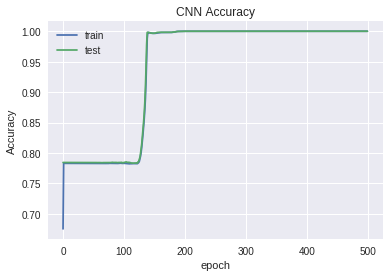

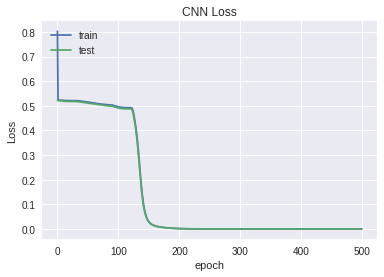

In [73]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('CNN Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [74]:
weight = model.get_weights()

In [75]:
weight

[array([[[ 5.6270267e+01],
         [-3.7824615e+01],
         [-4.2566544e+01],
         [-4.2668846e+01]],
 
        [[-5.5961708e+01],
         [-5.5962288e+01],
         [ 4.0327368e+00],
         [-5.5961220e+01]],
 
        [[-1.0200694e+01],
         [-7.0197815e+01],
         [-7.0197098e+01],
         [-7.0196129e+01]],
 
        [[-6.0047348e+01],
         [-5.2097656e-02],
         [-6.0047882e+01],
         [-6.0045948e+01]],
 
        [[-5.4580334e+01],
         [-5.4577290e+01],
         [-5.4578102e+01],
         [ 5.4149518e+00]],
 
        [[-3.9180489e+01],
         [-3.8522903e+01],
         [ 5.6008125e+01],
         [-3.9220814e+01]]], dtype=float32),
 array([-51.480915], dtype=float32),
 array([[327.6317]], dtype=float32),
 array([-16.121414], dtype=float32)]

['AGACTG']


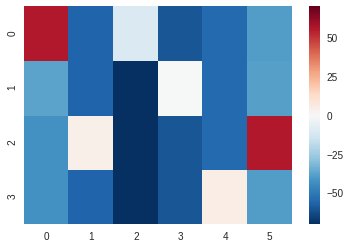

In [76]:
print(targetKmers)
convFilter = weight[0]
ax = sns.heatmap(convFilter[:,:,0].T)
plt.show()

# LASSO Regression

In [80]:
counts = pd.read_csv('Kmers6_counts_600bp.csv')

In [83]:
data.shape

(58959, 2081)

0.0001 0.7812756638379414 0.7839166666666667
0.001 0.8121178939684278 0.823
0.01 0.8330139611278401 0.8567291666666667
0.1 0.8349301943607993 0.8608333333333333
1 0.8354776895702163 0.8602916666666667


In [102]:
a_score

0.8354776895702163

In [87]:
clf.predict(test_features)

array([ 0.49416513,  0.36299136,  0.15559314, ...,  0.06244951,
       -0.03263932,  0.51914156])